In [2]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np

DOWNLOAD_ROOT = "http://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()
    
fetch_housing_data()

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


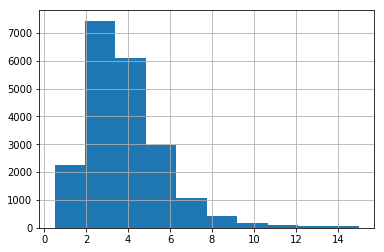

In [4]:
%matplotlib inline
housing["median_income"].hist()

In [5]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace = True)

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

housing = strat_test_set.drop('median_house_value', axis = 1)
housing_labels = strat_test_set['median_house_value'].copy()

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):

        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [9]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [10]:
housing_num = housing.drop('ocean_proximity', axis = 1)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

from sklearn.pipeline import FeatureUnion

preparation = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [21]:
housing_prepared = preparation.fit_transform(housing)
housing_labels.values.reshape(4128, 1)

array([[ 500001.],
       [ 240300.],
       [ 218200.],
       ..., 
       [ 311700.],
       [ 133500.],
       [  78600.]])

In [52]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
svm_reg = SVR()
param_grid = [
    {'kernel': ['linear'], 'C': [4000, 5000, 6000, 8000, 10000]}, 
]
grid_search = GridSearchCV(svm_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose=2, n_jobs=4)

In [53]:
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=4000, kernel=linear ...........................................
[CV] C=4000, kernel=linear ...........................................
[CV] C=4000, kernel=linear ...........................................
[CV] C=4000, kernel=linear ...........................................
[CV] ............................ C=4000, kernel=linear, total=   1.2s
[CV] C=4000, kernel=linear ...........................................
[CV] ............................ C=4000, kernel=linear, total=   1.2s
[CV] C=5000, kernel=linear ...........................................
[CV] ............................ C=4000, kernel=linear, total=   1.2s
[CV] C=5000, kernel=linear ...........................................
[CV] ............................ C=4000, kernel=linear, total=   1.2s
[CV] C=5000, kernel=linear ...........................................
[CV] ............................ C=4000, kernel=linear, total=   1.1s
[CV] C=5000, kern

[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   11.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [4000, 5000, 6000, 8000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2)

In [54]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)
print(grid_search.best_params_)

69555.6939837
{'C': 10000, 'kernel': 'linear'}


In [56]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(10000, 200000), 
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions = param_distribs, n_iter = 100, cv = 5, scoring = 'neg_mean_squared_error', verbose = 2, n_jobs = 4, random_state = 42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] C=30710.5736778, kernel=linear ..................................
[CV] C=30710.5736778, kernel=linear ..................................
[CV] C=30710.5736778, kernel=linear ..................................
[CV] C=30710.5736778, kernel=linear ..................................
[CV] ................... C=30710.5736778, kernel=linear, total=   2.3s
[CV] C=30710.5736778, kernel=linear ..................................
[CV] ................... C=30710.5736778, kernel=linear, total=   2.3s
[CV] C=17324.238895, kernel=rbf ......................................
[CV] ................... C=30710.5736778, kernel=linear, total=   3.2s
[CV] C=17324.238895, kernel=rbf ......................................
[CV] ....................... C=17324.238895, kernel=rbf, total=   1.3s
[CV] C=17324.238895, kernel=rbf ......................................
[CV] ................... C=30710.5736778, kernel=linear, total=   4.4s
[CV] C=17324.2

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   21.8s


[CV] ...................... C=83411.0643236, kernel=rbf, total=   1.4s
[CV] C=11841.1301989, kernel=rbf .....................................
[CV] ...................... C=11841.1301989, kernel=rbf, total=   1.2s
[CV] C=11841.1301989, kernel=rbf .....................................
[CV] ...................... C=11841.1301989, kernel=rbf, total=   1.2s
[CV] C=121068.96936, kernel=rbf ......................................
[CV] ...................... C=11841.1301989, kernel=rbf, total=   1.2s
[CV] C=121068.96936, kernel=rbf ......................................
[CV] ...................... C=11841.1301989, kernel=rbf, total=   1.2s
[CV] C=121068.96936, kernel=rbf ......................................
[CV] ...................... C=11841.1301989, kernel=rbf, total=   1.2s
[CV] C=121068.96936, kernel=rbf ......................................
[CV] ....................... C=121068.96936, kernel=rbf, total=   1.6s
[CV] C=121068.96936, kernel=rbf ......................................
[CV] .

[CV] ...................... C=46669.6376724, kernel=rbf, total=   1.3s
[CV] C=40482.9847577, kernel=linear ..................................
[CV] ...................... C=46669.6376724, kernel=rbf, total=   1.3s
[CV] C=40482.9847577, kernel=linear ..................................
[CV] ...................... C=46669.6376724, kernel=rbf, total=   1.3s
[CV] C=40482.9847577, kernel=linear ..................................
[CV] ................... C=40482.9847577, kernel=linear, total=   2.5s
[CV] C=40482.9847577, kernel=linear ..................................
[CV] ................... C=40482.9847577, kernel=linear, total=   2.7s
[CV] C=61721.1594811, kernel=linear ..................................
[CV] ................... C=40482.9847577, kernel=linear, total=   3.5s
[CV] C=61721.1594811, kernel=linear ..................................
[CV] ................... C=40482.9847577, kernel=linear, total=   2.8s
[CV] C=61721.1594811, kernel=linear ..................................
[CV] .

[CV] ...................... C=72771.5063417, kernel=rbf, total=   1.6s
[CV] C=72771.5063417, kernel=rbf .....................................
[CV] ...................... C=72771.5063417, kernel=rbf, total=   1.5s
[CV] C=35738.8476812, kernel=rbf .....................................
[CV] ...................... C=72771.5063417, kernel=rbf, total=   1.5s
[CV] C=35738.8476812, kernel=rbf .....................................
[CV] ...................... C=72771.5063417, kernel=rbf, total=   1.5s
[CV] C=35738.8476812, kernel=rbf .....................................


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.8min


[CV] ...................... C=72771.5063417, kernel=rbf, total=   1.5s
[CV] C=35738.8476812, kernel=rbf .....................................
[CV] ...................... C=35738.8476812, kernel=rbf, total=   1.3s
[CV] C=35738.8476812, kernel=rbf .....................................
[CV] ...................... C=35738.8476812, kernel=rbf, total=   1.3s
[CV] C=51438.2840508, kernel=rbf .....................................
[CV] ...................... C=35738.8476812, kernel=rbf, total=   1.2s
[CV] C=51438.2840508, kernel=rbf .....................................
[CV] ...................... C=35738.8476812, kernel=rbf, total=   1.3s
[CV] C=51438.2840508, kernel=rbf .....................................
[CV] ...................... C=35738.8476812, kernel=rbf, total=   1.3s
[CV] C=51438.2840508, kernel=rbf .....................................
[CV] ...................... C=51438.2840508, kernel=rbf, total=   1.3s
[CV] C=51438.2840508, kernel=rbf .....................................
[CV] .

[CV] ...................... C=29117.0102324, kernel=rbf, total=   1.5s
[CV] C=61626.8208964, kernel=linear ..................................
[CV] ...................... C=29117.0102324, kernel=rbf, total=   1.4s
[CV] C=61626.8208964, kernel=linear ..................................
[CV] ...................... C=29117.0102324, kernel=rbf, total=   1.3s
[CV] C=61626.8208964, kernel=linear ..................................
[CV] ................... C=61626.8208964, kernel=linear, total=   3.1s
[CV] C=61626.8208964, kernel=linear ..................................
[CV] ................... C=61626.8208964, kernel=linear, total=   4.6s
[CV] C=15252.6970305, kernel=linear ..................................
[CV] ................... C=61626.8208964, kernel=linear, total=   4.0s
[CV] C=15252.6970305, kernel=linear ..................................
[CV] ................... C=61626.8208964, kernel=linear, total=   4.2s
[CV] C=15252.6970305, kernel=linear ..................................
[CV] .

[CV] ...................... C=64703.7660423, kernel=rbf, total=   1.3s
[CV] C=64703.7660423, kernel=rbf .....................................
[CV] ...................... C=64703.7660423, kernel=rbf, total=   1.4s
[CV] C=13308.5709259, kernel=linear ..................................
[CV] ................... C=13308.5709259, kernel=linear, total=   1.3s
[CV] C=13308.5709259, kernel=linear ..................................
[CV] ...................... C=64703.7660423, kernel=rbf, total=   1.3s
[CV] C=13308.5709259, kernel=linear ..................................
[CV] ................... C=13308.5709259, kernel=linear, total=   1.5s
[CV] C=13308.5709259, kernel=linear ..................................
[CV] ................... C=13308.5709259, kernel=linear, total=   1.5s
[CV] C=13308.5709259, kernel=linear ..................................
[CV] ................... C=88809.6569877, kernel=linear, total=  38.1s
[CV] C=25386.1784565, kernel=rbf .....................................
[CV] .

[CV] ...................... C=13940.3052672, kernel=rbf, total=   1.2s
[CV] C=13815.607383, kernel=linear ...................................
[CV] .................... C=13815.607383, kernel=linear, total=   1.2s
[CV] C=13815.607383, kernel=linear ...................................
[CV] .................... C=13815.607383, kernel=linear, total=   1.3s
[CV] C=13815.607383, kernel=linear ...................................
[CV] .................... C=13815.607383, kernel=linear, total=   1.2s
[CV] C=146357.609357, kernel=linear ..................................
[CV] .................... C=13815.607383, kernel=linear, total=   1.2s
[CV] C=146357.609357, kernel=linear ..................................
[CV] .................... C=13815.607383, kernel=linear, total=   1.3s
[CV] C=146357.609357, kernel=linear ..................................
[CV] ................... C=146357.609357, kernel=linear, total=   5.4s
[CV] C=146357.609357, kernel=linear ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  4.8min


[CV] ................... C=50390.5910834, kernel=linear, total=   2.5s
[CV] C=19846.0132173, kernel=rbf .....................................
[CV] ...................... C=19846.0132173, kernel=rbf, total=   1.4s
[CV] C=19846.0132173, kernel=rbf .....................................
[CV] ...................... C=19846.0132173, kernel=rbf, total=   1.3s
[CV] C=19846.0132173, kernel=rbf .....................................
[CV] ...................... C=19846.0132173, kernel=rbf, total=   1.2s
[CV] C=60137.0244012, kernel=linear ..................................
[CV] ...................... C=19846.0132173, kernel=rbf, total=   1.2s
[CV] C=60137.0244012, kernel=linear ..................................
[CV] ...................... C=19846.0132173, kernel=rbf, total=   1.2s
[CV] C=60137.0244012, kernel=linear ..................................
[CV] ................... C=80331.7616314, kernel=linear, total=  18.3s
[CV] C=60137.0244012, kernel=linear ..................................
[CV] .

[CV] ................... C=69608.8204812, kernel=linear, total=   3.3s
[CV] C=115947.595664, kernel=linear ..................................
[CV] ................... C=69608.8204812, kernel=linear, total=   4.3s
[CV] C=115947.595664, kernel=linear ..................................
[CV] ................... C=69608.8204812, kernel=linear, total=   3.4s
[CV] C=115947.595664, kernel=linear ..................................
[CV] ................... C=69608.8204812, kernel=linear, total=   3.0s
[CV] C=115947.595664, kernel=linear ..................................
[CV] ................... C=115947.595664, kernel=linear, total=   4.3s
[CV] C=115947.595664, kernel=linear ..................................
[CV] ................... C=115947.595664, kernel=linear, total=   5.0s
[CV] C=24918.9396893, kernel=rbf .....................................
[CV] ................... C=115947.595664, kernel=linear, total=   5.3s
[CV] C=24918.9396893, kernel=rbf .....................................
[CV] .

[CV] ...................... C=21260.6392892, kernel=rbf, total=   1.3s
[CV] C=84466.6757481, kernel=linear ..................................
[CV] ................... C=84466.6757481, kernel=linear, total=   3.5s
[CV] C=84466.6757481, kernel=linear ..................................
[CV] ................... C=84466.6757481, kernel=linear, total=   3.5s
[CV] C=23473.9419991, kernel=linear ..................................
[CV] ................... C=84466.6757481, kernel=linear, total=   3.6s
[CV] C=23473.9419991, kernel=linear ..................................
[CV] ................... C=23473.9419991, kernel=linear, total=   1.6s
[CV] C=23473.9419991, kernel=linear ..................................
[CV] ................... C=84466.6757481, kernel=linear, total=   3.3s
[CV] C=23473.9419991, kernel=linear ..................................
[CV] ................... C=23473.9419991, kernel=linear, total=   1.5s
[CV] C=23473.9419991, kernel=linear ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  6.3min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a170b22e8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2)

In [57]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
print(rmse)
print(grid_search.best_params_)

57693.5964452
{'C': 10000, 'kernel': 'linear'}
